In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler ,StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from pyclustertend import hopkins


In [2]:
df=pd.read_csv('Mall_Customers.csv')

In [3]:
df

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


In [4]:
df=df[['Annual Income (k$)','Spending Score (1-100)']]

In [5]:
df

,Annual Income (k$),Spending Score (1-100)
0,15,39
1,15,81
2,16,6
3,16,77
4,17,40
...,...,...
195,120,79
196,126,28
197,126,74
198,137,18


In [6]:
df.isna().sum()

Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [7]:
x=df.values

We scale the data using MinMaxScaler to avoid large numerical ranges

In [8]:
scale=MinMaxScaler()

In [9]:
x_scaled=scale.fit_transform(x)

In [10]:
x_scaled

array([[0.        , 0.3877551 ],
       [0.        , 0.81632653],
       [0.00819672, 0.05102041],
       [0.00819672, 0.7755102 ],
       [0.01639344, 0.39795918],
       [0.01639344, 0.76530612],
       [0.02459016, 0.05102041],
       [0.02459016, 0.94897959],
       [0.03278689, 0.02040816],
       [0.03278689, 0.7244898 ],
       [0.03278689, 0.13265306],
       [0.03278689, 1.        ],
       [0.04098361, 0.14285714],
       [0.04098361, 0.7755102 ],
       [0.04098361, 0.12244898],
       [0.04098361, 0.79591837],
       [0.04918033, 0.34693878],
       [0.04918033, 0.66326531],
       [0.06557377, 0.28571429],
       [0.06557377, 0.98979592],
       [0.07377049, 0.34693878],
       [0.07377049, 0.73469388],
       [0.08196721, 0.04081633],
       [0.08196721, 0.73469388],
       [0.10655738, 0.13265306],
       [0.10655738, 0.82653061],
       [0.10655738, 0.31632653],
       [0.10655738, 0.6122449 ],
       [0.1147541 , 0.30612245],
       [0.1147541 , 0.87755102],
       [0.

In [11]:
n_samples = x_scaled.shape[0]
n_features = x_scaled.shape[1]
m = int(0.1 * n_samples)

In [12]:
n_features

2

In [147]:
nn = NearestNeighbors(n_neighbors=2)
nn.fit(x_scaled)

NearestNeighbors(n_neighbors=2)

***this code is to know the clustering tendency of a dataset using the Hopkins that determine whether the data is suitable for clustering or not***

In [148]:
u_distances = []
w_distances = []

In [149]:
for x in range(m):
    u = [random.uniform(0, 1) for x in range(n_features)]
    dist_u, x = nn.kneighbors([u], n_neighbors=1)
    u_distances.append(dist_u[0][0])

    rand_index = random.randint(0, n_samples - 1)
    w = x_scaled[rand_index]
    dist_w, x = nn.kneighbors([w], n_neighbors=2)
    w_distances.append(dist_w[0][1])

In [150]:
H = sum(u_distances) / (sum(u_distances) + sum(w_distances))
print("Hopkins Statistic:", round(H, 3))

Hopkins Statistic: 0.739


***Since Hopkins > 0.5 then data is good for clustring***

In [151]:
x_scaled = pd.DataFrame(x_scaled, columns=['Annual Income (k$)', 'Spending Score (1-100)'])

In [152]:
n = len(x_scaled)
empirical_k = int(np.sqrt(n / 2))
print(f"Empirical K estimate: {empirical_k}")

Empirical K estimate: 10


We applied Empirical which is =10 that is very high

In [153]:
inertias = []
silhouettes = []
k_range = range(2, 10)

In [154]:
for k in k_range:
    model = KMedoids(n_clusters=k, random_state=42)
    model.fit(x_scaled)
    inertias.append(model.inertia_)
    silhouettes.append(silhouette_score(x_scaled, model.labels_))

In [155]:
for k, score in zip(k_range, silhouettes):
    print(f"Silhouette Score for K={k}: {score}")

Silhouette Score for K=2: 0.3259393764901199
Silhouette Score for K=3: 0.4046912185938232
Silhouette Score for K=4: 0.4901276276696228
Silhouette Score for K=5: 0.27435183724260165
Silhouette Score for K=6: 0.43455114033131403
Silhouette Score for K=7: 0.4113186163288491
Silhouette Score for K=8: 0.37386051519025243
Silhouette Score for K=9: 0.33656614460091516


The best k in Silhouette=4

In [156]:
from sklearn.model_selection import KFold

for k in k_range:
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    scores = []
    for train_index, _ in kf.split(x_scaled):
        kmed = KMedoids(n_clusters=k, random_state=42).fit(x_scaled)
        score = silhouette_score(x_scaled, kmed.labels_)
        scores.append(score)
    print(f"K={k}, Avg Silhouette={np.mean(scores):.4f}")

K=2, Avg Silhouette=0.3259
K=3, Avg Silhouette=0.4047
K=4, Avg Silhouette=0.4901
K=5, Avg Silhouette=0.2744
K=6, Avg Silhouette=0.4346
K=7, Avg Silhouette=0.4113
K=8, Avg Silhouette=0.3739
K=9, Avg Silhouette=0.3366


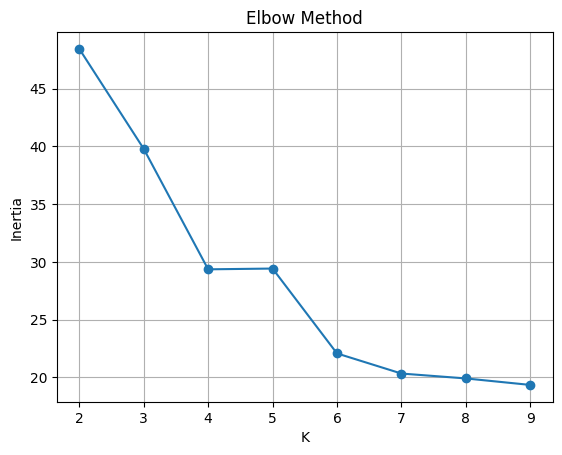

In [157]:
plt.plot(k_range, inertias, marker='o')
plt.title("Elbow Method")
plt.xlabel("K")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

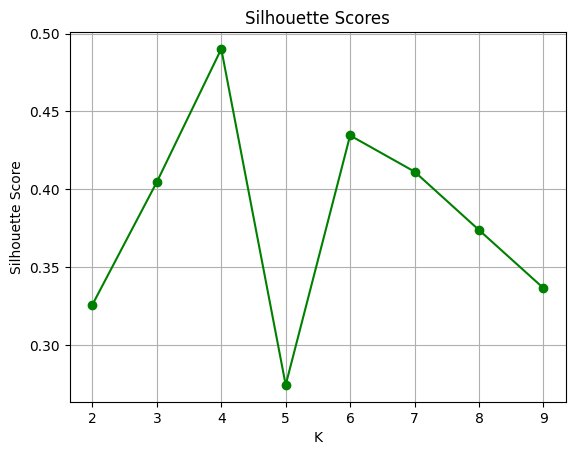

In [158]:
plt.plot(k_range, silhouettes, marker='o', color='green')
plt.title("Silhouette Scores")
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

from plots and cross validation we know that best k is 4

In [159]:
best_k = 4
kmedoids = KMedoids(n_clusters=best_k, random_state=0)
kmedoids.fit(x_scaled)
x_scaled['Cluster_KMedoids'] = kmedoids.labels_

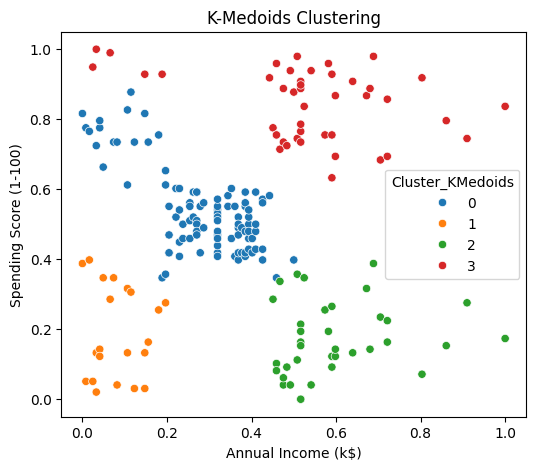

In [160]:
plt.figure(figsize=(6, 5))
sns.scatterplot(data=x_scaled, x='Annual Income (k$)', y='Spending Score (1-100)', hue='Cluster_KMedoids',palette='tab10')
plt.title("K-Medoids Clustering")
plt.show()

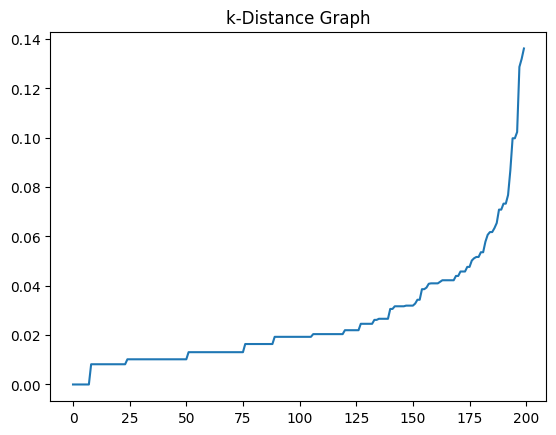

In [161]:
nn = NearestNeighbors(n_neighbors=2).fit(x_scaled)
k_dist = np.sort(nn.kneighbors(x_scaled)[0][:, -1])
plt.plot(k_dist)
plt.title("k-Distance Graph")
plt.show()

In [162]:
print("Silhouette Score:", silhouette_score(x_scaled,x_scaled['Cluster_KMedoids']))
print("Calinski-Harabasz Score:", calinski_harabasz_score(x_scaled, x_scaled['Cluster_KMedoids']))
print("Davies-Bouldin Score:", davies_bouldin_score(x_scaled, x_scaled['Cluster_KMedoids']))

Silhouette Score: 0.8156670251500268
Calinski-Harabasz Score: 3348.093563675806
Davies-Bouldin Score: 0.2602127549363533


In [163]:
x_scaled_d=x_scaled

In [164]:
dbscan = DBSCAN(eps=0.07, min_samples=3)
dbscan.fit(x_scaled_d[['Annual Income (k$)', 'Spending Score (1-100)']])
x_scaled_d['Cluster_DBSCAN'] = dbscan.labels_

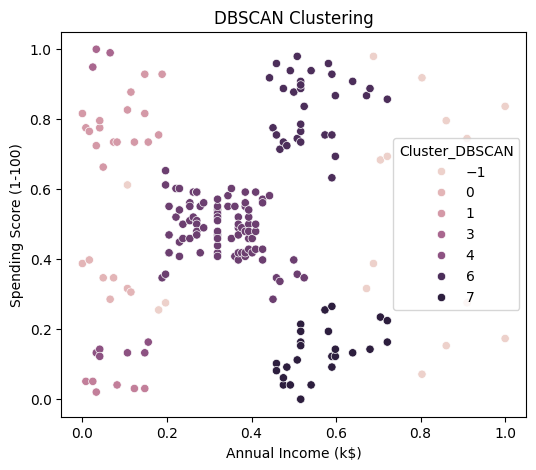

In [165]:
plt.figure(figsize=(6, 5))
sns.scatterplot(data=x_scaled_d, x='Annual Income (k$)', y='Spending Score (1-100)', hue='Cluster_DBSCAN')
plt.title("DBSCAN Clustering")
plt.show()

In [166]:
labels_db = x_scaled_d['Cluster_DBSCAN']
unique_labels = set(labels_db)
n_clusters = len(unique_labels) - (1 if -1 in labels_db else 0)

In [169]:
if n_clusters > 1:
    mask = labels_db != -1
    print("Silhouette Score:", silhouette_score(x_scaled_d[mask], labels_db[mask]))
    print("Calinski-Harabasz Score:", calinski_harabasz_score(x_scaled_d[mask], labels_db[mask]))
    print("Davies-Bouldin Score:", davies_bouldin_score(x_scaled_d[mask], labels_db[mask]))
else:
    print("DBSCAN didn't work well")

Silhouette Score: 0.8336168146916811
Calinski-Harabasz Score: 685.0081553677894
Davies-Bouldin Score: 0.30518773590794235


**kmedoids**

The Silhouette Score= 0.816
The Calinski-Harabasz Score= 3348.09
The Davies-Bouldin Score= 0.2602

**DBSCAN**

Silhouette Score: 0.834
Calinski-Harabasz Score: 685.008
Davies-Bouldin Score: 0.3051


***kmedoids shows better results across most metrices***